The goal of this notebook is to explore the "delta kick model", which is a way of working with the IDE where we decompose a laser pulse into a series of delta-function kicks. This lets us look at how time delays between parts of the pulse directly couple to the kernel, causing intereference and therefore changing the resulting ionization probability.

At the moment, this model has some pretty severe limits. Because we're changing the electric field, we can't really do anything involving the vector potential. This limits us to using the most-approximate versions of the IDE kernel, ones that have no dependence on the vector potential.

Most of the delta kick code was actually moved into the library a long time ago, so we'll just access it from there.

In [1]:
import logging
import os
import functools
import datetime

import numpy as np

import simulacra as si
import simulacra.units as u

import ionization as ion
import ionization.ide.delta_kicks as dk

LOGMAN = si.utils.LogManager('simulacra', 'ionization', stdout_level = logging.INFO)
THIS_DIR = os.getcwd()
OUT_DIR = os.path.join(THIS_DIR, 'out', 'DeltaKickModel')
SIM_LIB = os.path.join(OUT_DIR, 'SIMLIB')

PLOT_KWARGS = dict(
    show = True,
    save = True,
    target_dir = OUT_DIR,
    fig_dpi_scale = 1.5,
)

%matplotlib inline

The first thing we'll look at is a basic "sine-like" delta-kick. It's made of two kicks of opposite polarity. We'll center them around $t=0$ for convenience.

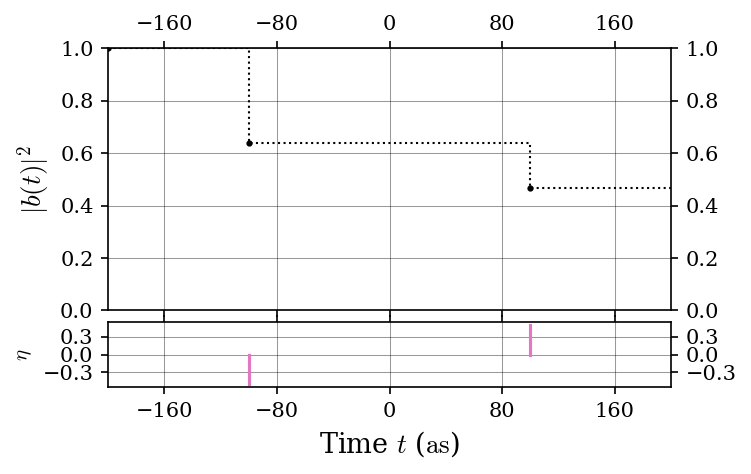

In [2]:
sine_kicks = dk.DeltaKicks([
    dk.delta_kick(-100 * u.asec, -.5 * u.atomic_electric_field * u.atomic_time),
    dk.delta_kick(100 * u.asec, .5 * u.atomic_electric_field * u.atomic_time),
])

sine_kick_sim = dk.DeltaKickSpecification(
    'sine_kick',
    time_initial = -200 * u.asec,
    time_final = 200 *  u.asec,
    electric_potential = sine_kicks,
    kernel = ion.ide.LengthGaugeHydrogenKernel(),
).to_sim()

sine_kick_sim.run()

sine_kick_sim.plot_b2_vs_time(**PLOT_KWARGS)

We can also seamlessly feed in an actual pulse. Well, almost seamlessly. We have to specify a pretty small time step to make sure that the decomposition algorithm catches every "chunck" of the field. For this pulse and time window, with $\Delta t = 1 \, \mathrm{as}$, the algorithm lumps the last lobe of the field in with the second central lobe. Reducing the time step to $\Delta t = 0.1 \, \mathrm{as}$ lets it get the right decomposition.

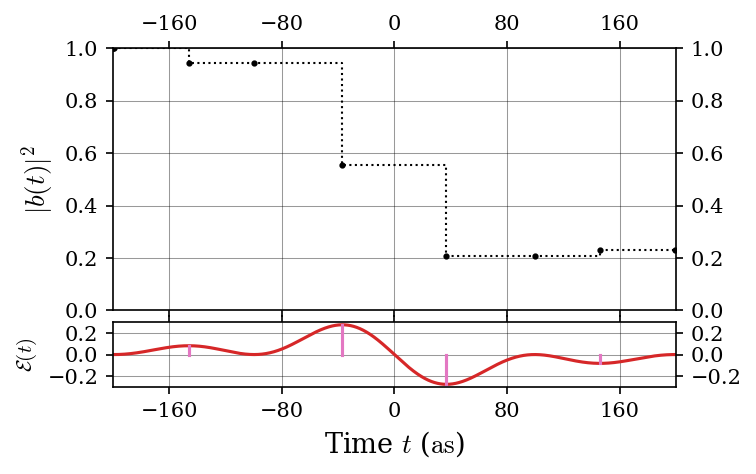

In [3]:
pulse = ion.potentials.SincPulse(pulse_width = 100 * u.asec, fluence = .5 * u.Jcm2, phase = u.pi / 2)

pulse_sim = dk.DeltaKickSpecification(
    'pulse',
    time_initial = -200 * u.asec,
    time_final = 200 *  u.asec,
    time_step = .1 * u.asec,
    electric_potential = pulse,
    kernel = ion.ide.LengthGaugeHydrogenKernel(),
).to_sim()

pulse_sim.run()

pulse_sim.plot_b2_vs_time(**PLOT_KWARGS)